In [1]:
import requests, zipfile, io
import sys, os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
# Download Data
import requests, zipfile, io
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

import os
import urllib.request
import zipfile
from random import shuffle
from math import floor


In [17]:
class ModelConfig(object):

	def __init__(self,):
		super(ModelConfig, self).__init__()
		self.seed = 1
		self.batch_size_cuda = 256
		self.batch_size_cpu = 128
		self.num_workers = 4
		# Regularization
		self.dropout = 0
		self.l1_decay = 0
		self.l2_decay = 5e-3
		self.lr = 0.001
		self.momentum = 0.9
		self.epochs = 15
		self.train_data_path = "/content/tiny-imagenet-200/train"
		self.url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
		self.target_zip = "/tiny-imagenet-200.zip"
		self.test_data_path = "/content/tiny-imagenet-200/val"


	def print_config(self):
		print("Model Parameters:")
		pprint.pprint(vars(self), indent=2)

In [18]:
# View model config
args = ModelConfig()
args.print_config()
print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'target_zip': '/tiny-imagenet-200.zip',
  'test_data_path': '/content/tiny-imagenet-200/val',
  'train_data_path': '/content/tiny-imagenet-200/train',
  'url': 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'}

CUDA Available


In [27]:
def download_dataset(args):
	print('Beginning dataset download with urllib2')
	url = args.url
  # url = args.url
	# url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
	temp = '%s'+args.target_zip
	path = temp % os.getcwd()
	# path = "%s/tiny-imagenet-200.zip" % os.getcwd()
	urllib.request.urlretrieve(url, path)
	print("Dataset downloaded")
 
download_dataset(args)

Beginning dataset download with urllib2
Dataset downloaded


In [4]:
def unzip_data(args):
	temp = '%s'+args.target_zip
	path_to_zip_file = temp % os.getcwd()
	# path_to_zip_file = "%s/tiny-imagenet-200.zip" % os.getcwd()
	directory_to_extract_to = os.getcwd()
	print("Extracting zip file: %s" % path_to_zip_file)
	with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
		zip_ref.extractall(directory_to_extract_to)
	print("Extracted at: %s" % directory_to_extract_to)

unzip_data(args)

Extracting zip file: /content/tiny-imagenet-200.zip
Extracted at: /content


In [5]:
def format_val():
	val_dir = "%s/tiny-imagenet-200/val" % os.getcwd()
	print("Formatting: %s" % val_dir)
	val_annotations = "%s/val_annotations.txt" % val_dir
	val_dict = {}
	with open(val_annotations, 'r') as f:
		for line in f:
			line = line.strip().split()
			assert(len(line) == 6)
			wnind = line[1]
			img_name = line[0]
			boxes = '\t'.join(line[2:])
			if wnind not in val_dict:
				val_dict[wnind] = []
			entries = val_dict[wnind]
			entries.append((img_name, boxes))
	assert(len(val_dict) == 200)
	for wnind, entries in val_dict.items():
		val_wnind_dir = "%s/%s" % (val_dir, wnind)
		val_images_dir = "%s/images" % val_dir
		val_wnind_images_dir = "%s/images" % val_wnind_dir
		os.mkdir(val_wnind_dir)
		os.mkdir(val_wnind_images_dir)
		wnind_boxes = "%s/%s_boxes.txt" % (val_wnind_dir, wnind)
		f = open(wnind_boxes, "w")
		for img_name, box in entries:
			source = "%s/%s" % (val_images_dir, img_name)
			dst = "%s/%s" % (val_wnind_images_dir, img_name)
			os.system("cp %s %s" % (source, dst))
			f.write("%s\t%s\n" % (img_name, box))
		f.close()
	os.system("rm -rf %s" % val_images_dir)
	print("Cleaning up: %s" % val_images_dir)
	print("Formatting val done")

In [6]:
format_val()

Formatting: /content/tiny-imagenet-200/val
Cleaning up: /content/tiny-imagenet-200/val/images
Formatting val done


In [7]:
from albumentations import (
	Compose,
    HorizontalFlip,
    Normalize,
    RandomCrop,
    PadIfNeeded,
    RGBShift,
    Rotate
)
from albumentations.pytorch import ToTensor
import numpy as np
import torchvision.transforms as transforms

def albumentations_transforms(p=1.0, is_train=False):
	# Mean and standard deviation of train dataset
	mean = np.array([0.4914, 0.4822, 0.4465])
	std = np.array([0.2023, 0.1994, 0.2010])
	transforms_list = []
	# Use data aug only for train data
	if is_train:
		transforms_list.extend([
			PadIfNeeded(min_height=72, min_width=72, p=1.0),
			RandomCrop(height=64, width=64, p=1.0),
			HorizontalFlip(p=0.25),
			Rotate(limit=15, p=0.25),
			RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.25),
			#CoarseDropout(max_holes=1, max_height=32, max_width=32, min_height=8,
						#min_width=8, fill_value=mean*255.0, p=0.5),
		])
	transforms_list.extend([
		Normalize(
			mean=mean,
			std=std,
			max_pixel_value=255.0,
			p=1.0
		),
		ToTensor()
	])
	data_transforms = Compose(transforms_list, p=p)
	return lambda img: data_transforms(image=np.array(img))["image"]

def torch_transforms(is_train=False):
	# Mean and standard deviation of train dataset
	mean = (0.4914, 0.4822, 0.4465)
	std = (0.2023, 0.1994, 0.2010)
	transforms_list = []
	# Use data aug only for train data
	if is_train:
		transforms_list.extend([
			transforms.RandomCrop(64, padding=4),
			transforms.RandomHorizontalFlip(),
		])
	transforms_list.extend([
		transforms.ToTensor(),
		transforms.Normalize(mean, std),
	])
	if is_train:
		transforms_list.extend([
			transforms.RandomErasing(0.25)
		])
	return transforms.Compose(transforms_list)

In [8]:
class DataEngine(object):

	classes = ["%s" % i for i in range(200)]

	def __init__(self, args):
		super(DataEngine, self).__init__()
		self.batch_size_cuda = args.batch_size_cuda
		self.batch_size_cpu = args.batch_size_cpu
		self.num_workers = args.num_workers
		self.train_data_path = args.train_data_path
		self.test_data_path = args.test_data_path
		self.load()


	def _transforms(self):
		# Data Transformations
		train_transform = albumentations_transforms(p=1.0, is_train=True)
		test_transform = albumentations_transforms(p=1.0, is_train=False)
		return train_transform, test_transform

	def _dataset(self):
		# Get data transforms
		train_transform, test_transform = self._transforms()

		# Dataset and Creating Train/Test Split
		train_set = torchvision.datasets.ImageFolder(root=self.train_data_path,
			transform=train_transform)
		test_set = torchvision.datasets.ImageFolder(root=self.test_data_path,
			transform=test_transform)
		return train_set, test_set

	def load(self):
		# Get Train and Test Data
		train_set, test_set = self._dataset()

		# Dataloader Arguments & Test/Train Dataloaders
		dataloader_args = dict(
			shuffle= True,
			batch_size= self.batch_size_cpu)
		if has_cuda():
			dataloader_args.update(
				batch_size= self.batch_size_cuda,
				num_workers= self.num_workers,
				pin_memory= True)

		self.train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
		self.test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

	def show_samples(self):
		# get some random training images
		dataiter = iter(self.train_loader)
		images, labels = dataiter.next()
		index = []
		num_img = min(len(self.classes), 10)
		for i in range(num_img):
			for j in range(len(labels)):
				if labels[j] == i:
					index.append(j)
					break
		if len(index) < num_img:
			for j in range(len(labels)):
				if len(index) == num_img:
					break
				if j not in index:
					index.append(j)
		imshow(torchvision.utils.make_grid(images[index],
				nrow=num_img, scale_each=True), "Sample train data")

In [9]:
# import torch
# import torchvision

# from .data_transforms import albumentations_transforms, torch_transforms
# from utils import has_cuda, imshow

def show_model_summary(model, input_size):
	print(summary(model, input_size=input_size))


def imshow(img, title):
	img = denormalize(img)
	npimg = img.numpy()
	fig = plt.figure(figsize=(15,7))
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.title(title)


def normalize(tensor, mean=[0.4914, 0.4822, 0.4465],
						std=[0.2023, 0.1994, 0.2010]):
	single_img = False
	if tensor.ndimension() == 3:
		single_img = True
		tensor = tensor[None,:,:,:]

	if not tensor.ndimension() == 4:
	    raise TypeError('tensor should be 4D')

	mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
	std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
	ret = tensor.sub(mean).div(std)
	return ret[0] if single_img else ret

def denormalize(tensor, mean=[0.4914, 0.4822, 0.4465],
						std=[0.2023, 0.1994, 0.2010]):
	single_img = False
	if tensor.ndimension() == 3:
		single_img = True
		tensor = tensor[None,:,:,:]

	if not tensor.ndimension() == 4:
	    raise TypeError('tensor should be 4D')

	mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
	std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
	ret = tensor.mul(std).add(mean)
	return ret[0] if single_img else ret



In [9]:
# zip_path = "/tiny-imagenet-200.zip"
# temp = '%s'+ zip_path
# path = temp % os.getcwd()
# path

'/content/tiny-imagenet-200.zip'

In [16]:
import pprint


def has_cuda():
	return torch.cuda.is_available()
 
def init_seed(args):
	torch.manual_seed(args.seed)

	if has_cuda():
		print("CUDA Available")
		torch.cuda.manual_seed(args.seed)



def test_config():
	args = ModelConfig()
	args.print_config()

if __name__ == '__main__':
	test_config()





Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'target_zip': '/tiny-imagenet-200.zip',
  'test_data_path': '/content/tiny-imagenet-200/val',
  'train_data_path': '/content/tiny-imagenet-200/train',
  'url': 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'}
Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'target_zip': '/tiny-imagenet-200.zip',
  'test_data_path': '/content/tiny-imagenet-200/val',
  'train_data_path': '/content/tiny-imagenet-200/train',
  'url': 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'}

CUDA Available


In [11]:
data = DataEngine(args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


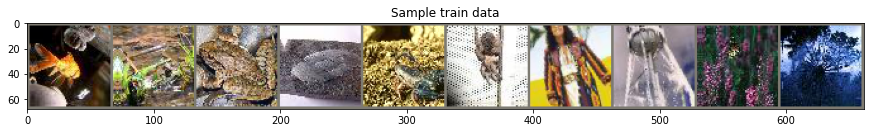

In [12]:
data.show_samples()

In [13]:
img, label = next(iter(data.train_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
label

tensor([126, 138,   6, 125,  15, 121,  20,  13,  35, 190,  63,  53,  39, 174,
          3, 181, 111,  15,  79,  87,  43, 161, 193, 130,   5, 168,  49, 154,
        123, 171, 125,   7, 187, 169, 174, 114,  86, 144, 173,  66,   0, 183,
        150, 167,  57,  35,   2,  47, 136,  34, 177,  66, 135,   5,   9, 186,
         13, 168,  56, 143, 194,  65, 147,   0,  67, 131,  50, 124,  82, 195,
        128,  34,  84, 116,  23, 108, 116,  57, 101, 175,  74, 110,  24,  52,
        150, 194, 145, 153,  44, 130, 139, 133,  35,   1, 172, 192, 116, 174,
         38,  44,  10,  92, 193,  13,   1, 176,  53, 101, 167,   8, 195, 181,
         35,  14,  84, 168,  36,  99,  67,  87,  87,  19, 131, 181, 199, 115,
         95, 162, 176, 175, 112, 110,  10, 192, 111,  49,  83,  23,  65,  96,
        157, 132, 153,   0,   2, 192, 114,  62, 161, 127, 163, 192,  47, 183,
        126,   6, 158, 153,  26, 104,  96, 129, 196, 115,  31,  71,  53,  34,
        127, 171, 132, 133,  26, 191, 180, 152,  33, 192, 128, 1

In [15]:
img, label = next(iter(data.test_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
label

tensor([185, 136,   9, 135,  42, 172,  45, 170,  82,  65,  93,   8, 132, 146,
        152, 123,  17,  18, 113,  76, 162, 179, 125,  64, 181, 155, 164, 141,
         48, 113, 127,  87, 130, 173, 165,  22,  17, 165,   1, 124,  52,  50,
         77,  66, 186,  16, 114, 131,  61, 117, 139,  11, 114, 135, 178, 149,
        130, 155,  11, 148,  22,  68,  95, 195, 125, 181, 139, 160,  97, 132,
         18, 116,  96,   2, 165, 171, 109, 196,  77,  35, 182, 177,   0, 101,
        129,  97, 176, 191,  36, 147,  61,  81, 195,   9, 140, 156, 111, 105,
        164,   6, 129,  94,  90, 172,  63,  57,  17,  66,  13,  96,  12,  66,
         51, 146,   6, 151,  17,  46, 100,  62,  68,  36,   7, 122, 143,  72,
         16,  35,  10, 197,  11,  20,  18, 145,  85, 163,  62,  78,  37, 151,
          6, 115, 172, 102,  89, 176, 193,  80, 110,  48,  31,  21,  96,  38,
        119,   1, 142,  97,  85, 119, 168, 135, 178,   5,  23, 102,  63,  54,
         70, 144, 143,  14, 114,  15,  53,   1, 168, 164,  14,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


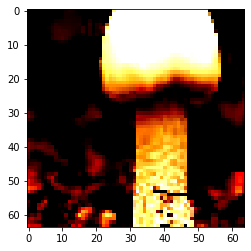

In [17]:
plt.imshow(img[0].numpy().squeeze().transpose(1,2,0), cmap='gray_r')

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.dropout = dropout

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.dropout)
        out = self.bn2(self.conv2(out))
        out = F.dropout(out, p=self.dropout)
        out += self.shortcut(x)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=200, dropout=0.0):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.dropout = dropout

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout=self.dropout))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.dropout)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=200, dropout=0.0):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes, dropout=dropout)

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

# test()


import torch
from tqdm import tqdm

def train(model, device, train_loader, criterion, optimizer, epoch,
          l1_decay, l2_decay, train_losses, train_accs, scheduler=None):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  avg_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    if l1_decay > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param,1)
      loss += l1_decay * l1_loss
    if l2_decay > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param,2)
      loss += l2_decay * l2_loss

    # Backpropagation
    loss.backward()
    optimizer.step()
    if scheduler:
      scheduler.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    avg_loss += loss.item()

    pbar_str = f'Loss={loss.item():0.5f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    if l1_decay > 0:
      pbar_str = f'L1_loss={l1_loss.item():0.3f} %s' % (pbar_str)
    if l2_decay > 0:
      pbar_str = f'L2_loss={l2_loss.item():0.3f} %s' % (pbar_str)

    pbar.set_description(desc= pbar_str)

  avg_loss /= len(train_loader)
  avg_acc = 100*correct/processed
  train_accs.append(avg_acc)
  train_losses.append(avg_loss)


def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc >= 90.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()



In [19]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = which_device()
model = ResNet18(num_classes=200).to(device)
show_model_summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [20]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(data.train_loader),
                       epochs=epochs, div_factor=10, final_div_factor=10,
                       pct_start=10/epochs)

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, False)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.002000)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
L2_loss=462.972 Loss=6.52807 Batch_id=390 Accuracy=6.27: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 4.2245, Accuracy: 1035/10000 (10.35%)

EPOCH: 2 (LR: 0.002441)


L2_loss=460.520 Loss=5.99102 Batch_id=390 Accuracy=15.17: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 3.7674, Accuracy: 1647/10000 (16.47%)

EPOCH: 3 (LR: 0.003720)


L2_loss=457.731 Loss=5.45265 Batch_id=390 Accuracy=21.67: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 3.3962, Accuracy: 2181/10000 (21.81%)

EPOCH: 4 (LR: 0.005712)


L2_loss=454.661 Loss=5.21769 Batch_id=390 Accuracy=27.61: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 3.2487, Accuracy: 2540/10000 (25.40%)

EPOCH: 5 (LR: 0.008222)


L2_loss=451.170 Loss=4.72545 Batch_id=390 Accuracy=32.45: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 3.1202, Accuracy: 2872/10000 (28.72%)

EPOCH: 6 (LR: 0.011004)


L2_loss=447.301 Loss=4.84048 Batch_id=390 Accuracy=36.82: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 3.3065, Accuracy: 2626/10000 (26.26%)

EPOCH: 7 (LR: 0.013785)


L2_loss=443.162 Loss=4.77409 Batch_id=390 Accuracy=39.94: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.8109, Accuracy: 3500/10000 (35.00%)

EPOCH: 8 (LR: 0.016294)


L2_loss=438.770 Loss=4.79066 Batch_id=390 Accuracy=43.12: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.8474, Accuracy: 3370/10000 (33.70%)

EPOCH: 9 (LR: 0.018285)


L2_loss=434.303 Loss=4.05615 Batch_id=390 Accuracy=45.54: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.7409, Accuracy: 3651/10000 (36.51%)

EPOCH: 10 (LR: 0.019562)


L2_loss=429.721 Loss=4.42721 Batch_id=390 Accuracy=48.20: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.6070, Accuracy: 3964/10000 (39.64%)

EPOCH: 11 (LR: 0.020000)


L2_loss=425.142 Loss=3.76937 Batch_id=390 Accuracy=50.28: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.9296, Accuracy: 3468/10000 (34.68%)

EPOCH: 12 (LR: 0.019877)


L2_loss=420.596 Loss=4.04913 Batch_id=390 Accuracy=52.37: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.3389, Accuracy: 4385/10000 (43.85%)

EPOCH: 13 (LR: 0.019514)


L2_loss=416.120 Loss=3.96078 Batch_id=390 Accuracy=54.31: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.4593, Accuracy: 4192/10000 (41.92%)

EPOCH: 14 (LR: 0.018919)


L2_loss=411.735 Loss=3.60967 Batch_id=390 Accuracy=56.32: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.3249, Accuracy: 4558/10000 (45.58%)

EPOCH: 15 (LR: 0.018107)


L2_loss=407.390 Loss=3.59554 Batch_id=390 Accuracy=57.99: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.3048, Accuracy: 4553/10000 (45.53%)

EPOCH: 16 (LR: 0.017098)


L2_loss=403.192 Loss=3.54619 Batch_id=390 Accuracy=59.65: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.1566, Accuracy: 4759/10000 (47.59%)

EPOCH: 17 (LR: 0.015916)


L2_loss=399.072 Loss=3.48246 Batch_id=390 Accuracy=61.25: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.0534, Accuracy: 5081/10000 (50.81%)

EPOCH: 18 (LR: 0.014591)


L2_loss=395.126 Loss=3.58331 Batch_id=390 Accuracy=62.74: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.2287, Accuracy: 4704/10000 (47.04%)

EPOCH: 19 (LR: 0.013155)


L2_loss=391.357 Loss=3.13977 Batch_id=390 Accuracy=64.58: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.0724, Accuracy: 5069/10000 (50.69%)

EPOCH: 20 (LR: 0.011645)


L2_loss=387.682 Loss=3.24546 Batch_id=390 Accuracy=66.29: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.0594, Accuracy: 5137/10000 (51.37%)

EPOCH: 21 (LR: 0.010096)


L2_loss=384.191 Loss=3.11948 Batch_id=390 Accuracy=68.52: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.0989, Accuracy: 5087/10000 (50.87%)

EPOCH: 22 (LR: 0.008547)


L2_loss=380.927 Loss=3.09934 Batch_id=390 Accuracy=70.31: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.1204, Accuracy: 5006/10000 (50.06%)

EPOCH: 23 (LR: 0.007037)


L2_loss=377.849 Loss=2.88669 Batch_id=390 Accuracy=72.75: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 2.0109, Accuracy: 5303/10000 (53.03%)

EPOCH: 24 (LR: 0.005602)


L2_loss=375.027 Loss=2.84702 Batch_id=390 Accuracy=75.13: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 1.8491, Accuracy: 5586/10000 (55.86%)

EPOCH: 25 (LR: 0.004278)


L2_loss=372.527 Loss=2.61627 Batch_id=390 Accuracy=78.02: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 1.7311, Accuracy: 5826/10000 (58.26%)

EPOCH: 26 (LR: 0.003097)


L2_loss=370.421 Loss=2.73604 Batch_id=390 Accuracy=81.07: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 1.7464, Accuracy: 5858/10000 (58.58%)

EPOCH: 27 (LR: 0.002088)


L2_loss=368.826 Loss=2.55124 Batch_id=390 Accuracy=83.99: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 1.6644, Accuracy: 6016/10000 (60.16%)

EPOCH: 28 (LR: 0.001277)


L2_loss=367.763 Loss=2.27699 Batch_id=390 Accuracy=86.55: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 1.6347, Accuracy: 6076/10000 (60.76%)

EPOCH: 29 (LR: 0.000683)


L2_loss=367.164 Loss=2.25155 Batch_id=390 Accuracy=88.58: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 1.6183, Accuracy: 6129/10000 (61.29%)

EPOCH: 30 (LR: 0.000321)


L2_loss=366.850 Loss=2.27400 Batch_id=390 Accuracy=89.45: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]


Test set: Average loss: 1.5956, Accuracy: 6155/10000 (61.55%)

